In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion, make_pipeline

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#!pip install dask
import dask.dataframe as dd
from datetime import datetime, date, time
# Для получения версии
import sklearn
import matplotlib
import dask

### Версии библиотек

In [2]:
print(f'The numpy version is {np.__version__}.')
print(f'The pandas version is {pd.__version__}.')
print(f'The dask version is {dask.__version__}.')
print(f'The sklearn version is {sklearn.__version__}.')
print(f'The matplotlib version is {matplotlib.__version__}.')
print(f'The seaborn version is {sns.__version__}.')

The numpy version is 1.20.1.
The pandas version is 1.2.4.
The dask version is 2021.04.0.
The sklearn version is 0.24.1.
The matplotlib version is 3.3.4.
The seaborn version is 0.11.1.


### Загрузка данных

In [3]:
path_train = 'data_train.csv'
path_test = 'data_test.csv'
path_features = 'features.csv'

In [4]:
df_train = pd.read_csv(path_train)

In [5]:
#data_train['buy_time'] = pd.to_datetime(data_train['buy_time'])
df_train['buy_time'] = df_train['buy_time'].apply(lambda x: date.fromtimestamp(x))

In [6]:
df_train.head()

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,2018-09-17,0.0
1,1,1454121,4.0,2018-07-16,0.0
2,2,2458816,1.0,2018-08-13,0.0
3,3,3535012,5.0,2018-09-03,0.0
4,4,1693214,1.0,2018-09-03,0.0


In [7]:
df_features = dd.read_csv('features.csv', sep='\t')
df_features['buy_time'] = df_features['buy_time'].apply(lambda x: date.fromtimestamp(x), meta=('buy_time', 'object'))
df_features.head()

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,0,2013026,2018-07-16,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,2018-10-15,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2,2015199,2018-12-24,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3,2021765,2018-08-13,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,4,2027465,2018-08-06,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0


In [8]:
df_merge = dd.merge(df_train, df_features, on=['id', 'buy_time'], how='inner')

In [9]:
df_merge.describe()

,Unnamed: 0_x,id,vas_id,target,Unnamed: 0_y,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
npartitions=1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

### Получаем тренировочный набор данных

In [10]:
df_merge['target'] = df_merge['target'].astype(int)

In [11]:
X_train = df_merge.drop('target', axis=1)

In [12]:
Y_train = df_merge['target']

In [13]:
Y_train.head()

0    0
1    1
2    0
3    0
4    0
Name: target, dtype: int32

In [14]:
y_list = []
y_list.append(df_train[df_train['target']==0].shape[0])
y_list.append(df_train[df_train['target']==1].shape[0])
print(f'target = 0 - {y_list[0]}, target = 1 - {y_list[1]}')

target = 0 - 771467, target = 1 - 60186


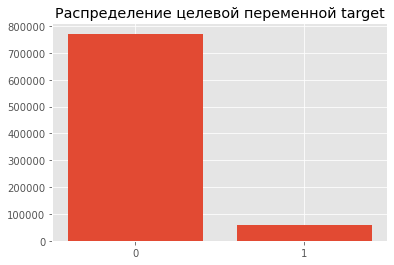

In [15]:
plt.style.use('ggplot')
fig, ax = plt.subplots()
ax.bar(np.arange(2), y_list)
ax.set(xticks=np.arange(2))
ax.set_title('Распределение целевой переменной target')
plt.show()

### Определение типа признаков

In [16]:
# Составление списка колонок датафрейма
columns = [col for col in X_train.columns]

In [17]:
# Выбор признаков для обработки в pipline 
for x in ['id', 'Unnamed: 0_x', 'Unnamed: 0_y']:
    columns.remove(x)

In [18]:
columns

['vas_id',
 'buy_time',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135'

In [19]:
# Преобразование двух признаков, для последующего занесения в категориальные
X_train['vas_id'] = X_train['vas_id'].astype(int)

In [20]:
X_train['buy_time'] = X_train['buy_time'].apply(lambda x: x.year, meta=('buy_time', 'object'))

#### Просмотр и оценка признаков
X_nunique = X_train.apply(lambda x: x.nunique(dropna=False), axis=1, meta=(None, 'int64'))
f_all = set(X_nunique.index)
len(f_all)
$\n$
f_const = set(X_nunique[X_nunique == 1].index)
len(f_const)
$\n$
f_other = columns
f_binary = set(X_train.loc[:, f_other].columns[(
                      (X_train.loc[:, f_other].max() == 1) & \
                      (X_train.loc[:, f_other].min() == 0) & \
                      (X_train.loc[:, f_other].isnull().sum() == 0))])
len(f_binary)
#### f_all = 142
#### f_const = 0
#### f_binary = 0

### Создание пайплайна

In [21]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, dd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)

In [22]:
columns.remove('vas_id')
columns.remove('buy_time')
f_numeric = columns
f_categorical = ['vas_id', 'buy_time']
f_binary = []
f_ok = f_binary + f_categorical + f_numeric

In [23]:
f_prep_pipeline = make_pipeline(
    ColumnSelector(columns=f_ok),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(f_numeric),
            SimpleImputer(strategy="mean"),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(f_categorical),
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(handle_unknown='ignore')
        )),
        ("boolean_features", make_pipeline(
            ColumnSelector(f_binary),
        ))
    ])
)

In [24]:
f_prep_pipeline.steps

[('columnselector',
  ColumnSelector(columns=['vas_id', 'buy_time', '0', '1', '2', '3', '4', '5', '6',
                          '7', '8', '9', '10', '11', '12', '13', '14', '15', '16',
                          '17', '18', '19', '20', '21', '22', '23', '24', '25',
                          '26', '27', ...])),
 ('featureunion',
  FeatureUnion(transformer_list=[('numeric_features',
                                  Pipeline(steps=[('columnselector',
                                                   ColumnSelector(columns=['0',
                                                                           '1',
                                                                           '2',
                                                                           '3',
                                                                           '4',
                                                                           '5',
                                                                   

In [25]:
f_prep_pipeline.fit(X_train)
n_features = f_prep_pipeline.transform(X_train).shape[1]
print(f'Количество обработанных признаков с помощью fit, transfofm - {n_features}')

Количество обработанных признаков с помощью fit, transfofm - 262


In [26]:
f_prep_pipeline

Pipeline(steps=[('columnselector',
                 ColumnSelector(columns=['vas_id', 'buy_time', '0', '1', '2',
                                         '3', '4', '5', '6', '7', '8', '9',
                                         '10', '11', '12', '13', '14', '15',
                                         '16', '17', '18', '19', '20', '21',
                                         '22', '23', '24', '25', '26', '27', ...])),
                ('featureunion',
                 FeatureUnion(transformer_list=[('numeric_features',
                                                 Pipeline(steps=[('columnselector',
                                                                  ColumnSelector(columns=['0',
                                                                                          '1',
                                                                                          '2...
                                                                 ('standardscaler',
                

### Gridsearch для пайплайнов

In [27]:
RANDOM_STATE = 1

In [28]:
lg_pipe = make_pipeline(
    f_prep_pipeline,
    LogisticRegression(random_state=RANDOM_STATE)
)

In [29]:
lg_pipe

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['vas_id', 'buy_time',
                                                          '0', '1', '2', '3',
                                                          '4', '5', '6', '7',
                                                          '8', '9', '10', '11',
                                                          '12', '13', '14',
                                                          '15', '16', '17',
                                                          '18', '19', '20',
                                                          '21', '22', '23',
                                                          '24', '25', '26',
                                                          '27', ...])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_features',
               

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [ ]:
kfold_cv = KFold(n_splits=3, shuffle=False, random_state=RANDOM_STATE)

In [31]:
def run_grid_search(estimator, X, y, params_grid, cv, scoring='roc_auc'):
    gsc = GridSearchCV(estimator, params_grid, scoring=scoring, cv=cv, n_jobs=-1)

    gsc.fit(X, y)
    print("Best %s score: %.2f" % (scoring, gsc.best_score_))
    print()
    print("Best parameters set found on development set:")
    print()
    print(gsc.best_params_)
    print()
    print("Grid scores on development set:")
    print()

    for i, params in enumerate(gsc.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (gsc.cv_results_['mean_test_score'][i], gsc.cv_results_['std_test_score'][i] * 2, params))

    print()
    
    return gsc

In [32]:
[k for k in lg_pipe.get_params().keys() if 'imputer' in k]

['pipeline__featureunion__numeric_features__simpleimputer',
 'pipeline__featureunion__numeric_features__simpleimputer__add_indicator',
 'pipeline__featureunion__numeric_features__simpleimputer__copy',
 'pipeline__featureunion__numeric_features__simpleimputer__fill_value',
 'pipeline__featureunion__numeric_features__simpleimputer__missing_values',
 'pipeline__featureunion__numeric_features__simpleimputer__strategy',
 'pipeline__featureunion__numeric_features__simpleimputer__verbose',
 'pipeline__featureunion__categorical_features__simpleimputer',
 'pipeline__featureunion__categorical_features__simpleimputer__add_indicator',
 'pipeline__featureunion__categorical_features__simpleimputer__copy',
 'pipeline__featureunion__categorical_features__simpleimputer__fill_value',
 'pipeline__featureunion__categorical_features__simpleimputer__missing_values',
 'pipeline__featureunion__categorical_features__simpleimputer__strategy',
 'pipeline__featureunion__categorical_features__simpleimputer__verbos

In [34]:
param_grid = {
    "pipeline__featureunion__categorical_features__simpleimputer__strategy": ['most_frequent', 'constant'],
    "pipeline__featureunion__categorical_features__simpleimputer__fill_value": [-1],
}

In [36]:
lg_gsc = run_grid_search(lg_pipe, X_train, Y_train, param_grid, kfold_cv)

NotImplementedError: 'DataFrame.iloc' only supports selecting columns. It must be used like 'df.iloc[:, column_indexer]'.